In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import datetime
import math
import time


from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer

warnings.filterwarnings('ignore')

def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 55]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

# Data Exploration

This notebook is themed at exploring the simulated dataset some more. We make minor tweaks to some fields in order to see correlations from the original simulated set itself, before any annoymisation or meta features added.

## Initial Thoughts
First, we look at the dataset in its original state, taking note of the size and data types for each column

In [2]:
# Read and count samples for simulated set
simulated_train = pd.read_csv("data/synthetic_train.csv")
simulated_test = pd.read_csv("data/synthetic_test.csv")
simulated_dataset = pd.concat([simulated_train, simulated_test])
del simulated_dataset['Unnamed: 0']
simulated_dataset.dataframeName = 'simulated'
simulated_dataset.rename_axis("index")
simulated_dataset.head(5)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [3]:
nRow, nCol = simulated_dataset.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1852394 rows and 22 columns


In [4]:
simulated_dataset.dtypes

trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
dtype: object

Clearly, there are a lot of fields that are unsuitable in their initial states, many stored as objects making it difficult for numerical evaluation. We now proceed to look at some of the distributions for some features.

## Feature Distributions
In this section, we look at some of the distributions of individual features

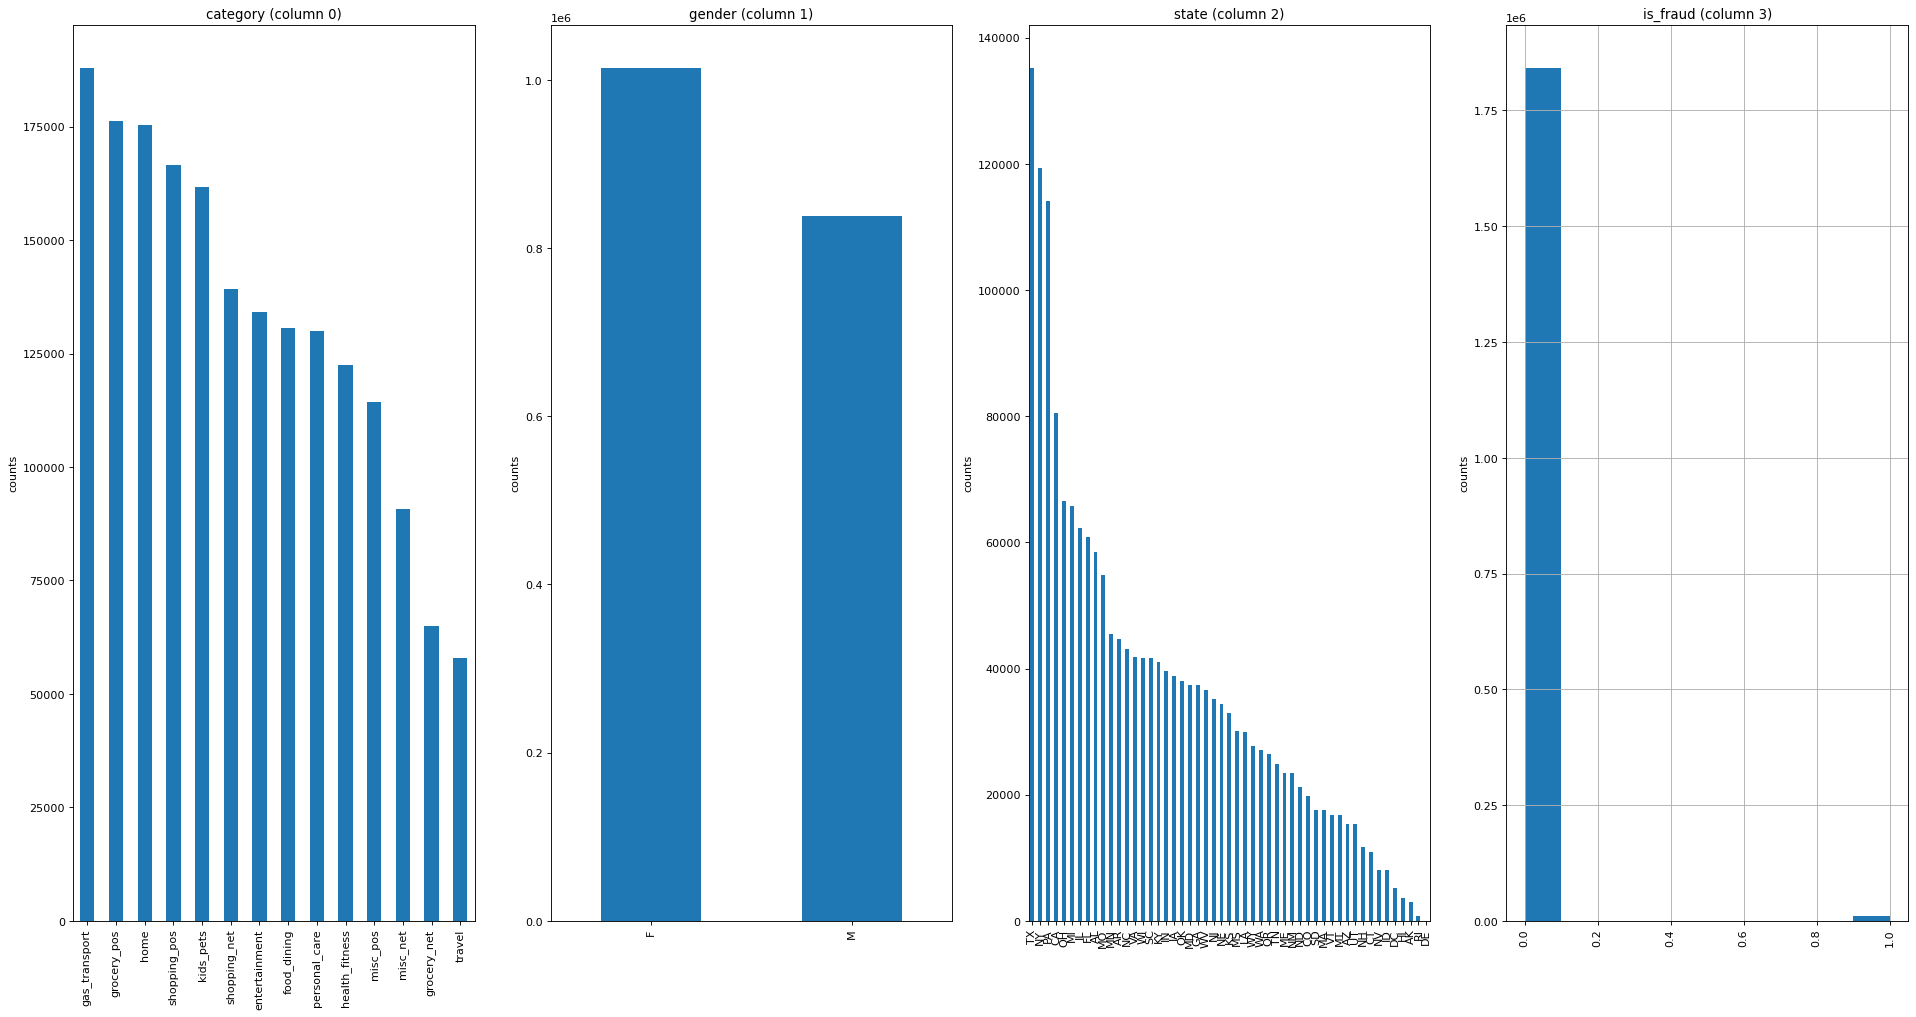

In [5]:
plotPerColumnDistribution(simulated_dataset, 13, 5)

Some features exhit reasonably long-tail distributions. It is also evident that the class imbalance is significant.

## Correlations
Now we look at correlations between features. We convert some categorical data to be numerical for this:

In [6]:
# Convert categorical data to numerical
simulated_dataset = simulated_dataset.replace('F', 0)
simulated_dataset = simulated_dataset.replace('M', 1)

simulated_dataset['category'] = pd.Categorical(simulated_dataset['category'])
simulated_dataset['category'] = simulated_dataset['category'].cat.codes

simulated_dataset['state'] = pd.Categorical(simulated_dataset['state'])
simulated_dataset['state'] = simulated_dataset['state'].cat.codes
simulated_dataset.dataframeName = 'simulated'

We then scale the data as noted in the real kaggle dataset kernel and plot the correlation matrix:

<AxesSubplot:title={'center':'Correlation of Numeric Features'}>

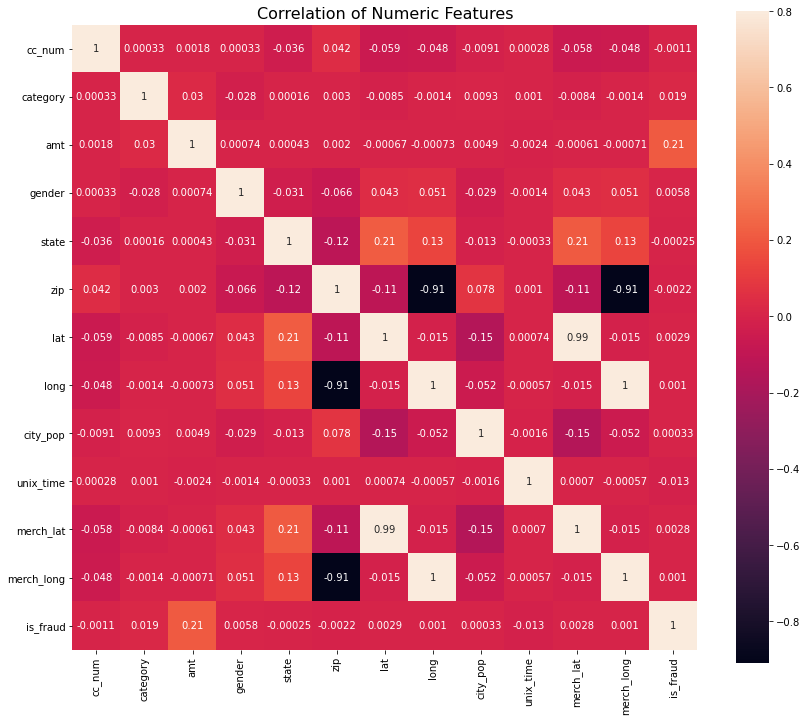

In [7]:
# RobustScaler is less prone to outliers.
std_scaler = StandardScaler()
rob_scaler = RobustScaler()

# Split dataset for further processing
numeric_features = simulated_dataset.select_dtypes(include=[np.number])

for column in numeric_features.columns:
    numeric_features[column] = rob_scaler.fit_transform(numeric_features[column].values.reshape(-1,1))
    
fraud = numeric_features[numeric_features['is_fraud']==1]
normal = numeric_features[numeric_features['is_fraud']==0][:9651]
    
df = numeric_features.sample(frac=1)
normal_distributed_df = pd.concat([fraud, normal])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()
    
f , ax = plt.subplots(figsize = (14,12))
plt.title('Correlation of Numeric Features',y=1,size=16)
sns.heatmap(numeric_features.corr(),square = True,  vmax=0.8, annot=True)

Clearly, there is not many features that attribute to fraudulent transactions, other than the amount. We now look at a box plot, along with a comparison between fraud and non_fraud stats:

Text(0.5, 1.0, 'is_fraud vs amt Positive Correlation')

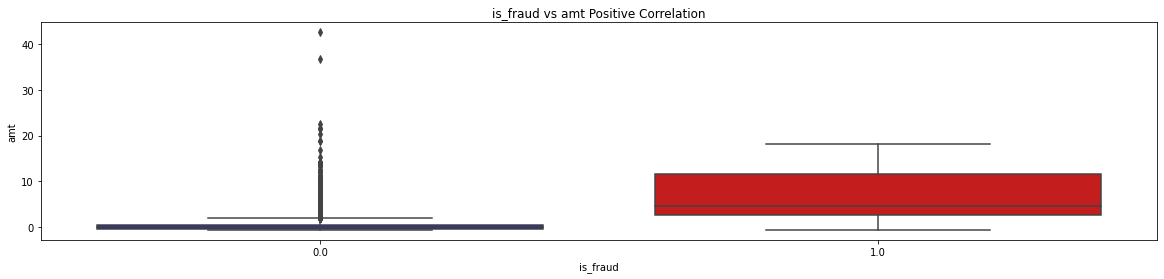

In [8]:
f, ax = plt.subplots(figsize=(20,4))
sns.boxplot(x="is_fraud", y="amt", data=new_df, palette=["#0101DF", "#DF0101"], ax=ax)
ax.set_title('is_fraud vs amt Positive Correlation')

In [9]:
# See Overall stats
pd.concat([fraud.amt.describe(), normal.amt.describe()], axis=1)

,amt,amt
count,9651.000000,9651.000000
mean,6.577885,0.249583
std,5.323018,1.405167
min,-0.631500,-0.632181
25%,2.622175,-0.515383
50%,4.663082,0.007487
75%,11.637830,0.471549
max,18.085897,42.622652


## Time and Amount of Transactions

In this section, we have a closer look at how much a fradulent or non-fraudulent transaction spends, along with at what time of day (using unix time). We begin with the amount:

(0.0, 0.1)

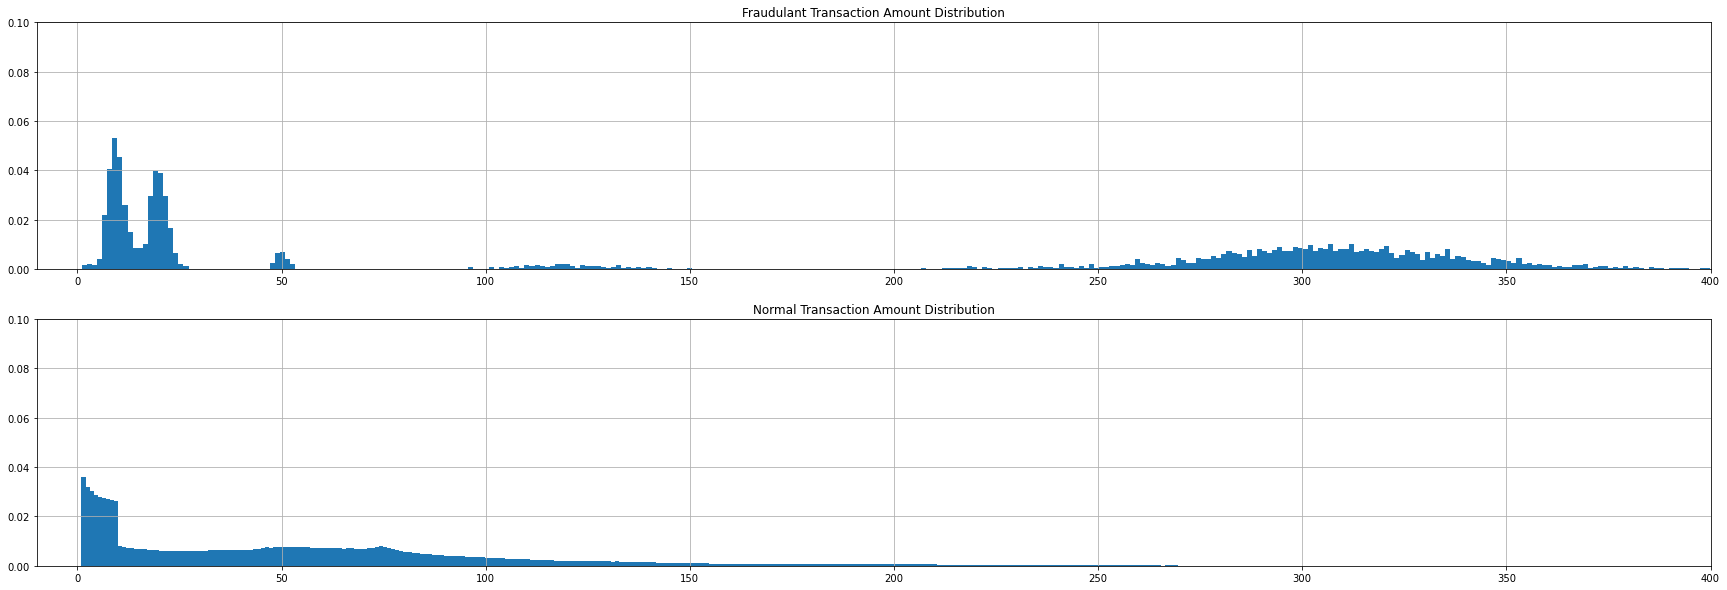

In [10]:
og_fraud = simulated_dataset[simulated_dataset['is_fraud']==1]
og_normal = simulated_dataset[simulated_dataset['is_fraud']==0]

plt.figure(figsize=(30, 10))

print()
plt.subplot(2, 1, 1)
subfraud = og_fraud[og_fraud.amt<500]
subfraud.amt.hist(bins=400,weights=np.ones(len(subfraud.amt)) / len(subfraud.amt))
plt.title("Fraudulant Transaction Amount Distribution")
plt.xlim([-10,400])
plt.ylim([0,0.1])

plt.subplot(2, 1, 2)
subnormal = og_normal[og_normal.amt<500]
subnormal.amt.hist(bins=500, weights=np.ones(len(subnormal.amt)) / len(subnormal.amt))
plt.title("Normal Transaction Amount Distribution")
plt.xlim([-10,400])
plt.ylim([0,0.1])

It is evident that fraudulent transactions tend to spend more than non-fraudulent, with reasonably proporitons in the hundereds of dollars. Now we look at time:

(0.0, 0.15)

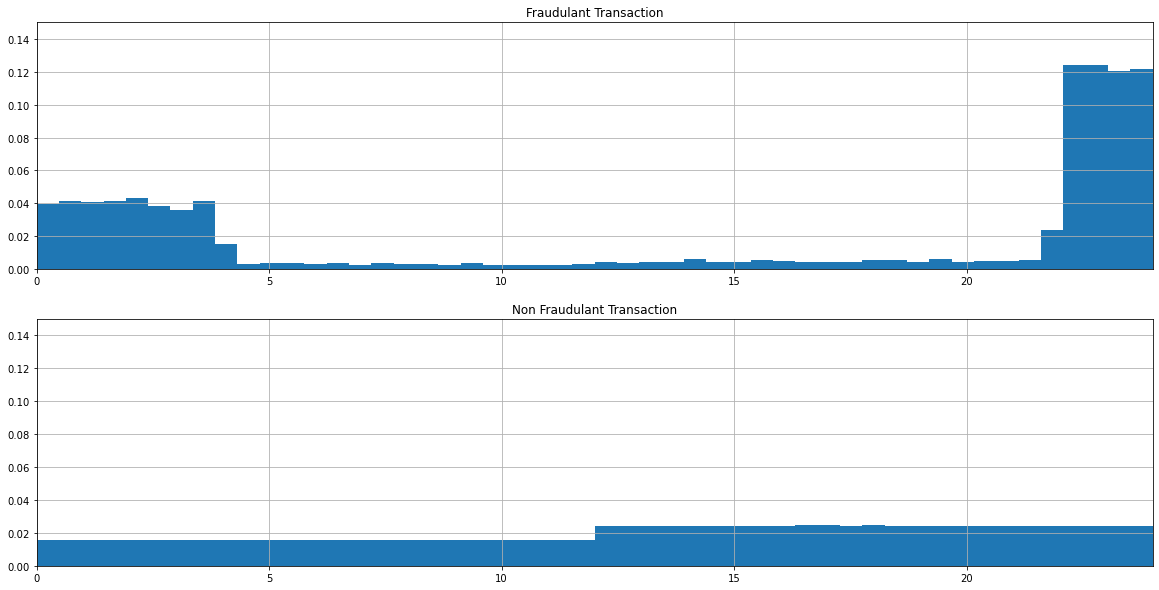

In [11]:
# plot hist 
plt.figure(figsize=(20, 10))

plt.subplot(2, 1, 1)
fraud_24time = og_fraud.copy()
fraud_24time.unix_time = fraud_24time.unix_time % 86400 #(86400s per 24h)
fraud_24time.unix_time /= (86400/24)
fraud_24time.unix_time.hist(bins=50,weights=np.ones(len(fraud_24time)) / len(fraud_24time))
plt.title("Fraudulant Transaction")
plt.xlim([0,24])
plt.ylim([0,0.15])
plt.xlabel("")

plt.subplot(2, 1, 2)
normal_24time = og_normal.copy()
normal_24time.unix_time  = normal_24time.unix_time  % 86400 #(86400s per 24h)
normal_24time.unix_time /= (86400/24)
normal_24time.unix_time.hist(bins=50, weights=np.ones(len(normal_24time)) / len(normal_24time))
plt.title("Non Fraudulant Transaction")
plt.xlim([0,24])
plt.ylim([0,0.15])

From this, we can infer that fraudulent transactions tend to take place between 22:00 - 04:00, whereas normal transactions are reasonably balanced throughout the day.

## Average Spend per hour
We not take a look at the average amount spent per hour of day for fraudulent and non-fraudulent transactions

In [12]:
simulated_cluster = simulated_dataset
simulated_cluster['unix_time'] = simulated_cluster['unix_time'].apply(lambda x: x % 86400)
simulated_cluster['unix_time'] = simulated_cluster['unix_time'].apply(lambda x: int((24 * x) / 86400))

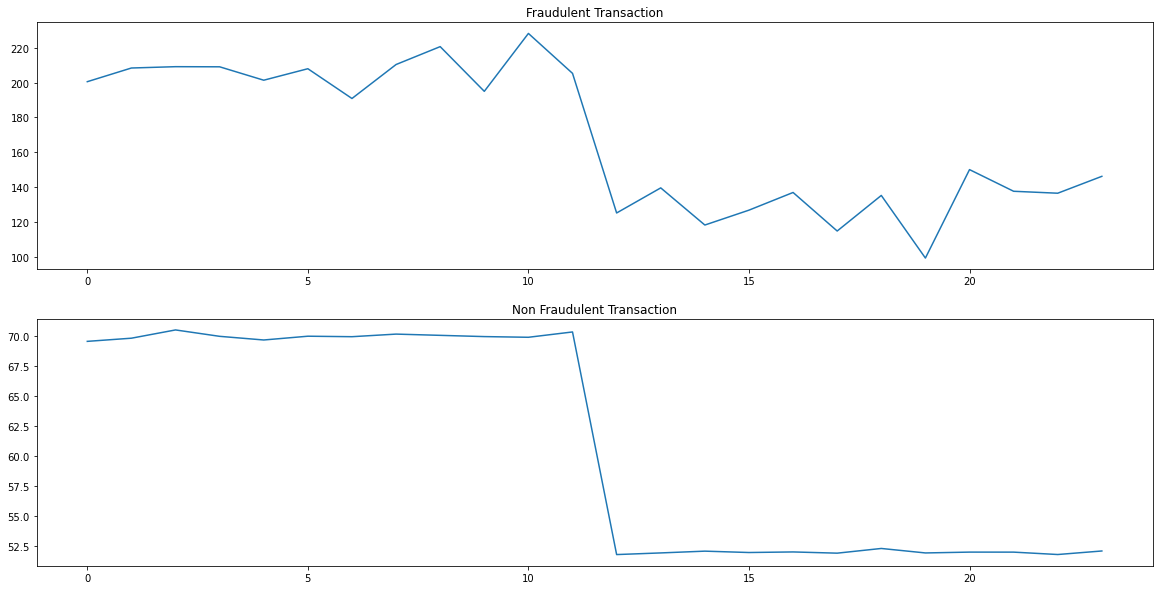

In [13]:
fraud_cluster = simulated_cluster[simulated_cluster['is_fraud'] == 1]
normal_cluster = simulated_cluster[simulated_cluster['is_fraud'] == 0]

fraud_cluster = fraud_cluster[fraud_cluster['amt'] < 500]
normal_cluster = normal_cluster[normal_cluster['amt'] < 500]

times = [t for t in range(24)]
fraud_averages = [fraud_cluster[fraud_cluster['unix_time'] == t]['amt'].mean() for t in range(24)]
normal_averages = [normal_cluster[normal_cluster['unix_time'] == t]['amt'].mean() for t in range(24)]


fig, ([ax1, ax2]) = plt.subplots(nrows=2, figsize=(20, 10))

ax1.plot(times, fraud_averages)
ax1.set_title("Fraudulent Transaction")
ax2.plot(times, normal_averages)
ax2.set_title("Non Fraudulent Transaction")
plt.show()

It appears both types spend more in the first 12 hours of the day, before dropping in the final 12 hours. However, the drop/divide is a lot more drastic in non fradulent transactions.

## Feature Scatter Plots
Now we look at how features correlate with each other.

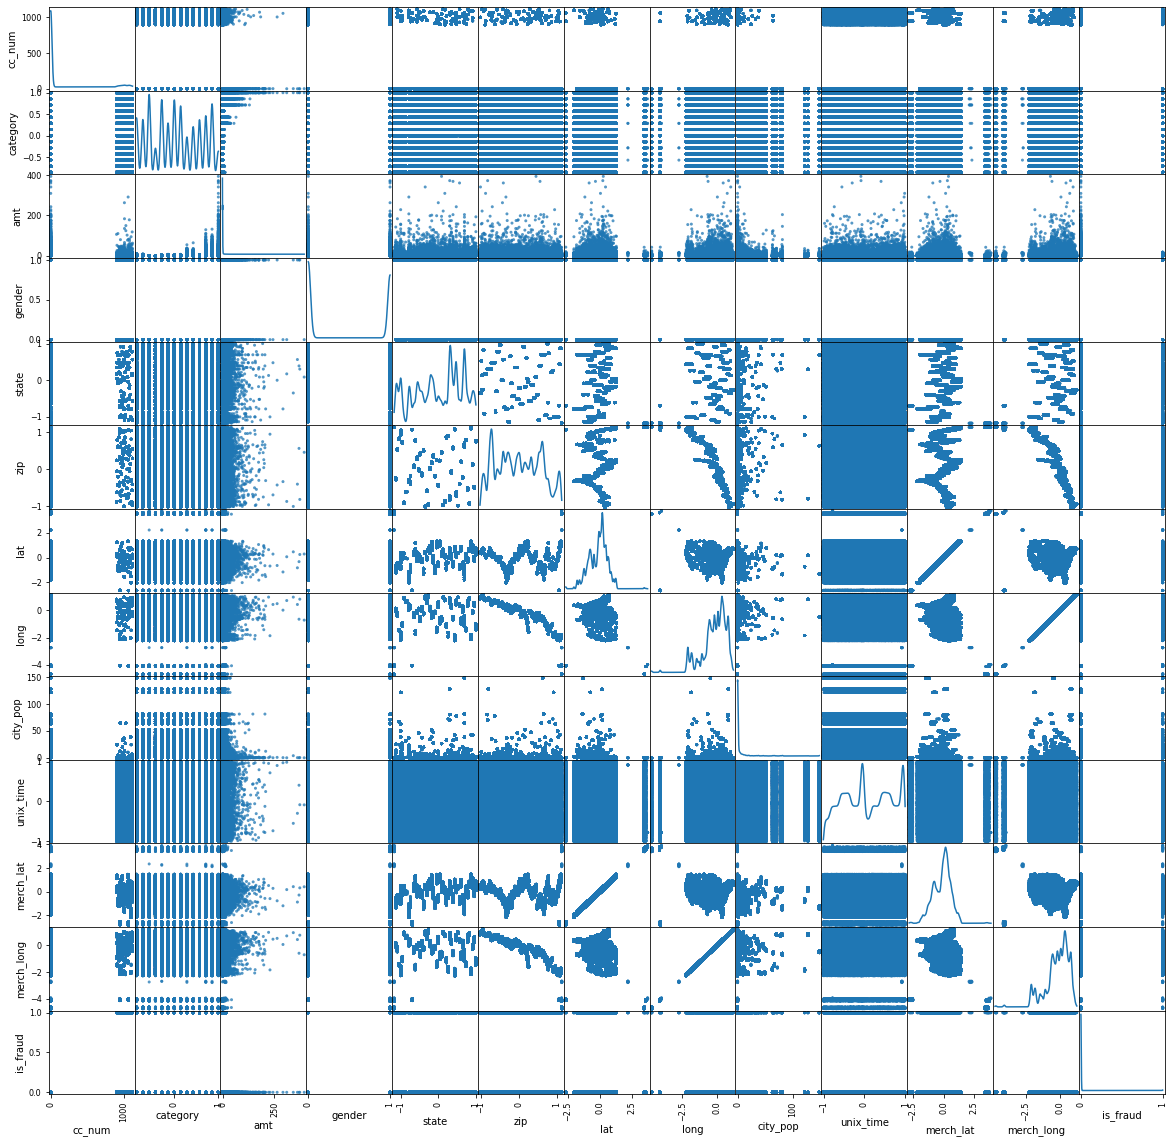

In [17]:
# FRAUD SCATTER PLOT
plotSize=20
textSize=10
df = numeric_features[numeric_features['is_fraud'] == 1]

fig, ([ax1, ax2, ax3]) = plt.subplots(nrows=3, figsize=[plotSize, plotSize])
fig.suptitle('Scatter and Density Plot')

# Remove rows and columns that would lead to df being singular
df = df.dropna('columns')
df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
pd.plotting.scatter_matrix(df, alpha=0.75, diagonal='kde', ax=ax1)
ax1.set_title("Fraudlent Transactions")
corrs = df.corr().values
# for i, j in zip(*plt.np.triu_indices_from(ax1, k = 1)):
#     ax1[i, j].annotate('CC: %.3f' % corrs[i, j], xy=(0.5, 0.9), xycoords='axes fraction', bbox =dict(boxstyle ="round", fc ="0.8"), ha='center', va='center', size=textSize)


# NON FRAUD SCATTER PLOT
plotSize=20
textSize=10
df = numeric_features[numeric_features['is_fraud'] == 0]
# Remove rows and columns that would lead to df being singular
df = df.dropna('columns')
df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde', ax=ax2)
ax2.set_title("Non Fraudlent Transactions")
corrs = df.corr().values
# for i, j in zip(*plt.np.triu_indices_from(ax2, k = 1)):
#     ax2[i, j].annotate('CC: %.3f' % corrs[i, j], xy=(0.5, 0.9), xycoords='axes fraction', bbox =dict(boxstyle ="round", fc ="0.8"), ha='center', va='center', size=textSize)

# WHOLE SCATTER PLOT
plotSize=20
textSize=10
df = numeric_features
df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde', ax=ax3)
ax3.set_title("All Transactions")
corrs = df.corr().values
# for i, j in zip(*plt.np.triu_indices_from(ax3, k = 1)):
#     ax3[i, j].annotate('CC: %.3f' % corrs[i, j], xy=(0.5, 0.9), xycoords='axes fraction', bbox =dict(boxstyle ="round", fc ="0.8"), ha='center', va='center', size=textSize)

plt.show()

Again, there is weak correlations between features with the exception of long/merch_long etc.